In [34]:
 %load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [36]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

### Import processor

In [37]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [38]:
UsingDaskExecutor = True
CoffeaCasaEnv     = False
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = True     ### True if run only on one file

tag = '_L5'

exec('from CoffeaJERCProcessor'+tag+' import Processor') 

add_tag = '' # '_testing_19UL18' # ''
tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

In [39]:
## assume running on the LPC
xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
# dataset = 'fileNames_QCD20UL18.txt'
dataset = 'dataset.txt'


rootfiles = open(dataset).read().split()

fileslist = [xrootdstr + file for file in rootfiles]

In [40]:
# to test on one file, uncomment the line below

fileslist = fileslist
if test_run:
    fileslist = [fileslist[0]]
    ### The smallest file in the RunIISummer20UL18NanoAODv9 dataset
#     fileslist = ['root://cms-xrd-global.cern.ch//'+
#                  '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']
# fileslist


Test if certificate works opening the file

In [41]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [42]:
import uproot

In [43]:
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

### Test if certificate works (but this doesn't work on singularity :()

In [44]:
# fileslist2 = ['root://cms-xrd-global.cern.ch//'+
#                  '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']


In [45]:
# fileslist2

In [46]:
# import awkward as ak
# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# events = NanoEventsFactory.from_root(fileslist2[0], schemaclass=NanoAODSchema).events()

# events
# events.Generator.fields

# events.GenJet
# events.GenJet.fields
# events.GenJet.partonFlavour
# np.where((events.GenJet.hadronFlavour!=0).to_numpy)

# a = np.array([1,0,2,3,0])
# b = np.array([2,0,1,3,0])


In [47]:
# events.GenJet.fields

In [48]:
# arr = (events.GenJet.partonFlavour==5) | (events.GenJet.partonFlavour==-5)
# arra = np.array(arr.tolist())

In [49]:
# arra = np.array((events.GenJet.hadronFlavour!=0).tolist())

In [50]:
# fin = []
# for nn, li in enumerate(arra):
#     bla = np.where(li)
#     if len(bla[0])!=0:
#         fin.append([nn,bla])

In [51]:
# events.GenJet.hadronFlavour[18]

In [52]:
# fin

In [53]:
# len(arra)

In [54]:
# import ROOT as R

In [55]:
# R.TFile.Open(fileslist[0])

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [56]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [57]:
# Dask set up for LPC only 
if(UsingDaskExecutor and not CoffeaCasaEnv):
#     from lpcjobqueue import LPCCondorCluster
#     cluster = LPCCondorCluster()
#     cluster.adapt(minimum=1, maximum=10)
#     client = Client(cluster)
#     client.upload_file('CoffeaJERCProcessor.py')
    
    
    from dask.distributed import Client
#     client=Client()
#     cluster.adapt(minimum=1, maximum=10)
    client = Client()
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')
# client

/opt/conda/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34912 instead
  warnings.warn(


{'tcp://127.0.0.1:33704': {'status': 'OK'},
 'tcp://127.0.0.1:37537': {'status': 'OK'},
 'tcp://127.0.0.1:38200': {'status': 'OK'},
 'tcp://127.0.0.1:39545': {'status': 'OK'},
 'tcp://127.0.0.1:43364': {'status': 'OK'}}

In [58]:
# dataset_axis = hist.Cat("dataset", "Primary dataset")
# cats_axis = hist.Cat("anacat", "Analysis Category")

# jetpt_axis = hist.Bin("pt", r"$p_T$", ptbins)
# ptresponse_axis = hist.Bin("ptresponse", "RECO / GEN response", 100, 0, 5)
# jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
# jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", etabins)
# jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)

In [59]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

filesets = {'QCD': fileslist}

if not load_preexisting:
    for name,files in filesets.items(): 
        if not UsingDaskExecutor:
            chosen_exec = 'futures'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.iterative_executor,
        #                                        executor=processor.futures_executor,
                                              executor_args={
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
                                                  'workers': 2},
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])
        else:
            chosen_exec = 'dask'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.dask_executor,
                                              executor_args={
                                                  'client': client,
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
    #                                               'workers': 2
                                              },
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    util.save(output, outname)
    outputs_unweighted[name] = output
    print(name + ' unweighted output loaded')
else:
    # output = util.load('out/CoffeaJERCOutputs_binned.coffea')
    output = util.load(outname)
    
elapsed = time.time() - tstart

Output:
{'ptresponse_b': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f35956e5460>, 'ptresponse_c': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f353f6fad90>, 'ptresponse_l': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f35956e57f0>, 'ptresponse_g': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f35956e58b0>, 'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f353ffda3a0>, 'jetpt': <Hist (dataset,pt) instance at 0x7f35956e5850>, 'jeteta': <Hist (dataset,jeteta) instance at 0x7f35956e5a00>, 'cutflow': defaultdict_accumulator(<class 'int'>, {})}


In [ ]:
print("Output:")
print(output)

### Fit responses

In [94]:
# define gaussian function for fitting the responses
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [64]:
# ptbins = output['ptresponse'].axis('pt').edges()
# ptbins;
# etabins = output['ptresponse'].axis('jeteta').edges()[:-1]
# etabins;

In [65]:
# # jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
# jetpt_length = len(ptbins)
# # jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
# jeteta_length = len(etabins)

# mean = np.zeros((jetpt_length, jeteta_length))
# median = np.zeros((jetpt_length, jeteta_length))
# width = np.zeros((jetpt_length, jeteta_length))
# idx = []

In [66]:
# for k in range(len(etabins)-1):
#     print(hist.Interval(etabins[k], etabins[k+1]))
# print()    
# for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
#     print(etaBin)

Define some global variables for the fit

In [96]:
f_xvals = np.linspace(0,5,5001)
ptbins = output['ptresponse'].axis('pt').edges()
etabins = output['ptresponse'].axis('jeteta').edges()[:-1]
jetpt_length = len(ptbins)
jeteta_length = len(etabins)

In [97]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.160

In [70]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 


# xvals = output['ptresponse'+samp].axis('ptresponse').centers()

# FitFigDir = 'fig/response_pt_eta'+samp+tag
# if not os.path.exists(FitFigDir):
#     os.mkdir(FitFigDir)

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')

    mean = np.zeros((jetpt_length, jeteta_length))
    median = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
    chi2s = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/response_pt_eta'+samp+tag_full
    print("Images will be saved under ", FitFigDir)
    if not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
    plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
    hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
    plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

    xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,5,5001)


    for i in range(len(ptbins)-1):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
        print('-'*25)
        print('pt bin '+str(ptBin))
        print('-'*25)

        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(len(etabins)-1):

            etaBin = hist.Interval(etabins[k], etabins[k+1])
            print("etaBin = ", etaBin ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histo = output['ptresponse'+samp].integrate('jeteta', etaBin).integrate('pt', ptBin) 
            histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
            yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

            try:
                p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                N_converge += 1

                            ### Second Gaussian
                xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
                xvals2 = xvals[xfit_l: xfit_h]
                yvals2 = yvals[xfit_l: xfit_h]
                p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                ygaus = gauss(xvals, *p2)
                chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                Ndof = len(xvals)-3
                if chi2<50000:
                    pass
                    print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
                else:
                    print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
            except:
    #             print("Fit failed because of non-convergance, p = ", p)
                N_not_converge += 1
                continue


#             fgaus = gauss(f_xvals, *p)
            fgaus2 = gauss(f_xvals, *p2)

            median[i,k] = np.median(histvals)
            mean[i,k] = p2[1] # - (scal-1)
            width[i,k] = p2[2]
            chi2s[i,k] = chi2
#             idx.append(i)

   ####################### Plotting ############################
            if not test_run:
                N = histo.integrate('ptresponse').values()[('QCD',)]
                histo = histo.rebin('ptresponse', plot_response_axis)

                h = np.max(histo.values()[('QCD',)]);
                h = h if h!=0 else 0.05
                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm{1:0.3f}$'.format(p2[2],np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
                plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
                ax2.legend();

                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf');
                plt.close();                

    warnings.filterwarnings('default')
    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, width, median, chi2s]
    

In [72]:
# subsamples = ['', '_b', '_c', '_l', '_g']
subsamples = ['', '_b']

In [73]:
# fit_responses(output, '')

In [74]:
def plotCorrections(mean, samp):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    # h = np.max(histo.values()[('QCD',)])
    fig, ax = plt.subplots()
    start = 17
    k0 = np.where(etabins<=-5)[0][-1]
    k4 = np.where(etabins<=-3)[0][-1]
    k1 = np.where(etabins<=-2.5)[0][-1]
    k5 = np.where(etabins<=-1.3)[0][-1]
    k2 = np.where(etabins<=0)[0][-1]
    k3 = np.where(etabins<=1.3)[0][-1]


    # ax.plot(ptbins[start:],mean_p[start:,k0], 'o', label=f'${etabins[k0]}<\eta<{etabins[k0+1]}$')
    ax.plot(ptbins[start:],mean_p[start:,k4], 'o', label=f'${etabins[k4]}<\eta<{etabins[k4+1]}$')
    ax.plot(ptbins[start:],mean_p[start:,k1], 'o', label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
    ax.plot(ptbins[start:],mean_p[start:,k5], 'o', label=f'${etabins[k5]}<\eta<{etabins[k5+1]}$')
    # ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
    # ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')

    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.set_xscale('log')
    # ax.set_ylim([0.8,1.1])
    ax.legend()
    if test_run:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'_test.pdf');
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');

    plt.show();
    
# plotCorrections()

In [85]:
def saveData(data, name):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins)}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    return df

### Run fitting for each sample

-------------------------
-------------------------
Fitting subsample:  
Images will be saved under  fig/response_pt_eta_L5
-------------------------
pt bin [1, 2)
-------------------------
etaBin =  [-5, -3) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-3, -2.5) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-2.5, -1.3) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-1.3, 0) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [0, 1.3) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [1.3, 2.5) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000

Fit failed because of high chi2, p =  [9.46288966 0.86961248 0.49454126] , chi2 =  9887103034.01813
-------------------------
pt bin [13, 14)
-------------------------
etaBin =  [-5, -3) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [38.652627    1.00550794  0.38337935] , chi2 =  14832718502.844141
etaBin =  [-3, -2.5) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [12.00680512  0.91711168  0.53671677] , chi2 =  14032573033.294748
etaBin =  [-2.5, -1.3) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [40.12686794  0.90455156 -0.51602657] , chi2 =  2842696587.4350348
etaBin =  [-1.3, 0) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [66.95703367  0.96679707 -0.35185737] , chi2 =  617490655.610671
etaBin =  [0, 1.3) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [60.03996246  0.8940961  -0.41516486] , chi2 =  23908247242.090347
etaBin =  [1.3, 2.5) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [39.2918594   0.89620213  0.

etaBin =  [-3, -2.5) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [2.94278189e+02 9.93696528e-01 1.35759285e-01] , chi2 =  947660.2646647352
etaBin =  [-2.5, -1.3) , ptBin =  [72, 90)
Fit converged, p =  [ 1.24694961e+03  1.00245261e+00 -1.34368519e-01] , chi2 =  505.93551543560915
etaBin =  [-1.3, 0) , ptBin =  [72, 90)
Fit converged, p =  [ 2.19832897e+03  1.00390973e+00 -1.15248329e-01] , chi2 =  1576.935318946862
etaBin =  [0, 1.3) , ptBin =  [72, 90)
Fit converged, p =  [ 2.14201129e+03  1.00125434e+00 -1.19384241e-01] , chi2 =  267.634673356914
etaBin =  [1.3, 2.5) , ptBin =  [72, 90)
Fit converged, p =  [ 1.23909905e+03  1.00237954e+00 -1.36856330e-01] , chi2 =  150.75300648614424
etaBin =  [2.5, 3) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [3.00072498e+02 1.00063682e+00 1.39734128e-01] , chi2 =  69003612.74794644
-------------------------
pt bin [90, 120)
-------------------------
etaBin =  [-5, -3) , ptBin =  [90, 120)
Fit failed because of high ch

etaBin =  [-1.3, 0) , ptBin =  [1500, 2000)
etaBin =  [0, 1.3) , ptBin =  [1500, 2000)
etaBin =  [1.3, 2.5) , ptBin =  [1500, 2000)
Fit converged, p =  [2.33364365e+02 9.99329687e-01 6.08191092e-02] , chi2 =  45.299048237190874
etaBin =  [2.5, 3) , ptBin =  [1500, 2000)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
-------------------------
pt bin [2000, 2500)
-------------------------
etaBin =  [-5, -3) , ptBin =  [2000, 2500)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-3, -2.5) , ptBin =  [2000, 2500)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-2.5, -1.3) , ptBin =  [2000, 2500)
Fit failed because of high chi2, p =  [32.12732521  1.01305157  0.05878633] , chi2 =  37124439.47115607
etaBin =  [-1.3, 0) , ptBin =  [2000, 2500)
etaBin =  [0, 1.3) , ptBin =  [2000, 2500)
etaBin =  [1.3, 2.5) ,

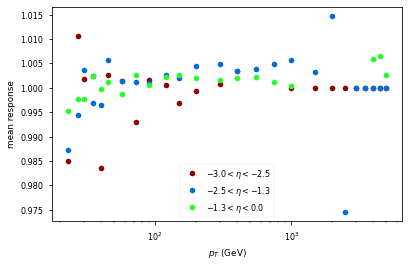

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1000.0,1500.0,2000.0,2500.0,3000.0,3500.0,4000.0,4500.0,5000.0,10000.0
etaBins,,,,,,,,,,,,,,,,,,,,,
-5.0,1.0,1.0,1.825000,0.980259,1.059657,1.179692,1.141947,1.072565,1.008278,1.004947,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
-3.0,1.0,1.0,1.025000,0.000000,1.091080,0.921137,0.707566,0.819980,0.964715,0.865909,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
-2.5,1.0,1.0,1.301173,0.967527,0.620753,0.757579,0.671073,0.724308,0.797386,0.771015,...,1.005725,1.003199,1.014600,0.974656,1.0,1.0,1.000000,1.000000,1.000000,0.0
-1.3,1.0,1.0,1.372456,0.682987,0.355301,0.731281,0.731044,0.726042,0.804266,0.818856,...,1.000353,0.000000,0.000000,0.000000,0.0,0.0,1.005912,1.006512,1.002704,0.0
0.0,1.0,1.0,0.754971,0.831173,0.567156,0.728533,0.748970,0.725122,0.802746,0.801058,...,1.000596,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.005123,1.002232,0.0
1.3,1.0,1.0,1.537243,0.882937,0.846606,0.752033,0.726471,0.729406,0.771006,0.738960,...,1.001302,0.999468,0.980124,0.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
2.5,1.0,1.0,1.000000,0.872127,1.137264,0.881600,1.190330,0.897930,1.011203,0.915629,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
3.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1000.0,1500.0,2000.0,2500.0,3000.0,3500.0,4000.0,4500.0,5000.0,10000.0
etaBins,,,,,,,,,,,,,,,,,,,,,
-5.0,1.0,1.0,0.070715,0.475460,0.483059,0.617471,0.565375,0.523739,0.474954,0.479460,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
-3.0,1.0,1.0,0.212140,0.000000,0.661765,0.483157,0.457482,0.671115,0.650282,0.540457,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
-2.5,1.0,1.0,0.618708,0.573820,0.266929,0.292654,0.415495,0.484251,0.542770,0.568359,...,-0.064789,0.065332,0.062363,-0.074055,1.0,1.0,1.000000,1.000000,1.000000,0.0
-1.3,1.0,1.0,0.339827,0.736315,0.839543,0.534356,0.451882,0.611795,0.527073,0.519022,...,0.050896,0.000000,0.000000,0.000000,0.0,0.0,-0.046455,-0.048759,-0.052022,0.0
0.0,1.0,1.0,0.302832,0.408116,0.497032,0.435127,0.550812,0.593179,0.502284,0.516940,...,0.050435,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-0.047743,-0.051224,0.0
1.3,1.0,1.0,1.375975,0.817240,0.699812,0.523218,0.474167,0.643653,0.645468,0.608847,...,0.062601,0.064411,0.064097,0.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
2.5,1.0,1.0,1.000000,0.339672,0.468641,0.591132,0.785001,0.797448,0.627400,0.714467,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
3.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1000.0,1500.0,2000.0,2500.0,3000.0,3500.0,4000.0,4500.0,5000.0,10000.0
etaBins,,,,,,,,,,,,,,,,,,,,,
-5.0,1.0,1.0,0.070715,0.475460,0.483059,0.617471,0.565375,0.523739,0.474954,0.479460,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
-3.0,1.0,1.0,0.212140,0.000000,0.661765,0.483157,0.457482,0.671115,0.650282,0.540457,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
-2.5,1.0,1.0,0.618708,0.573820,0.266929,0.292654,0.415495,0.484251,0.542770,0.568359,...,-0.064789,0.065332,0.062363,-0.074055,1.0,1.0,1.000000,1.000000,1.000000,0.0
-1.3,1.0,1.0,0.339827,0.736315,0.839543,0.534356,0.451882,0.611795,0.527073,0.519022,...,0.050896,0.000000,0.000000,0.000000,0.0,0.0,-0.046455,-0.048759,-0.052022,0.0
0.0,1.0,1.0,0.302832,0.408116,0.497032,0.435127,0.550812,0.593179,0.502284,0.516940,...,0.050435,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-0.047743,-0.051224,0.0
1.3,1.0,1.0,1.375975,0.817240,0.699812,0.523218,0.474167,0.643653,0.645468,0.608847,...,0.062601,0.064411,0.064097,0.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
2.5,1.0,1.0,1.000000,0.339672,0.468641,0.591132,0.785001,0.797448,0.627400,0.714467,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0
3.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


-------------------------
-------------------------
Fitting subsample:  _b
Images will be saved under  fig/response_pt_eta_b_L5
-------------------------
pt bin [1, 2)
-------------------------
etaBin =  [-5, -3) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-3, -2.5) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-2.5, -1.3) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-1.3, 0) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [0, 1.3) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [1.3, 2.5) , ptBin =  [1, 2)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.0000

etaBin =  [-1.3, 0) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [3.3823911  1.03766167 0.1438085 ] , chi2 =  3277088839.7670846
etaBin =  [0, 1.3) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [2.06119578 0.84296757 0.35446402] , chi2 =  10763137538.738373
etaBin =  [1.3, 2.5) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [1.68897279 0.95746849 0.39339172] , chi2 =  8638617490.862171
etaBin =  [2.5, 3) , ptBin =  [13, 14)
Fit failed because of high chi2, p =  [0.45733019 0.88373243 0.18175668] , chi2 =  878467440.063359
-------------------------
pt bin [14, 15)
-------------------------
etaBin =  [-5, -3) , ptBin =  [14, 15)
Fit failed because of high chi2, p =  [0.41869499 0.95011968 0.64355358] , chi2 =  2666821560.856985
etaBin =  [-3, -2.5) , ptBin =  [14, 15)
Fit failed because of high chi2, p =  [0.34528767 0.7786051  0.60371515] , chi2 =  1868995898.3754754
etaBin =  [-2.5, -1.3) , ptBin =  [14, 15)
Fit failed because of high chi2, p =  [1.5

Fit failed because of high chi2, p =  [10.21711581  0.9704392   0.09518506] , chi2 =  3835800.464734368
etaBin =  [-2.5, -1.3) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [46.79957572  0.98711958 -0.13228523] , chi2 =  442573839.1452682
etaBin =  [-1.3, 0) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [85.87078713  0.99502421  0.12240131] , chi2 =  33851809.44037009
etaBin =  [0, 1.3) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [81.76776663  0.98776752  0.12576393] , chi2 =  512743012.45361805
etaBin =  [1.3, 2.5) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [45.54557501  0.97846356  0.1315388 ] , chi2 =  255969275.67203116
etaBin =  [2.5, 3) , ptBin =  [72, 90)
Fit failed because of high chi2, p =  [ 8.7997985   1.00393138 -0.08863377] , chi2 =  104960690.57936482
-------------------------
pt bin [90, 120)
-------------------------
etaBin =  [-5, -3) , ptBin =  [90, 120)
Fit failed because of high chi2, p =  [3.82770165 0.92315602 0

etaBin =  [1.3, 2.5) , ptBin =  [2000, 2500)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [2.5, 3) , ptBin =  [2000, 2500)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
-------------------------
pt bin [2500, 3000)
-------------------------
etaBin =  [-5, -3) , ptBin =  [2500, 3000)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-3, -2.5) , ptBin =  [2500, 3000)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [-2.5, -1.3) , ptBin =  [2500, 3000)
etaBin =  [-1.3, 0) , ptBin =  [2500, 3000)
etaBin =  [0, 1.3) , ptBin =  [2500, 3000)
etaBin =  [1.3, 2.5) , ptBin =  [2500, 3000)
Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60
etaBin =  [2.5, 3) , ptBin =  [2500, 3000)
Fit converged, 

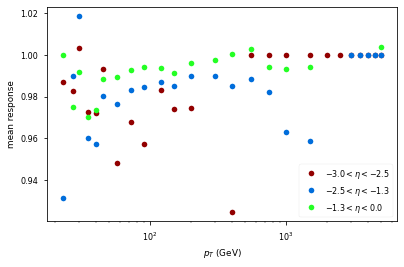

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1000.0,1500.0,2000.0,2500.0,3000.0,3500.0,4000.0,4500.0,5000.0,10000.0
etaBins,,,,,,,,,,,,,,,,,,,,,
-5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.825000,1.147049,0.946168,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,1.159345,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
-2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.359025,1.133314,...,0.963121,0.958751,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
-1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.185424,0.919269,0.989423,...,0.993261,0.993929,0.0,0.0,0.0,0.0,0.0,0.0,1.003645,0.0
0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.555898,0.796642,1.051859,...,0.993373,0.987255,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.257993,1.013834,...,0.981582,0.993229,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.996334,-0.680010,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1000.0,1500.0,2000.0,2500.0,3000.0,3500.0,4000.0,4500.0,5000.0,10000.0
etaBins,,,,,,,,,,,,,,,,,,,,,
-5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.141433,0.571207,0.714933,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.145785,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
-2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.258722,0.590760,...,0.069808,-0.082017,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
-1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.541975,0.259405,0.578291,...,0.047767,0.049029,0.0,0.0,0.0,0.0,0.0,0.0,0.049971,0.0
0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.646855,0.428206,0.277015,...,0.049002,0.044415,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.578311,0.410998,...,0.061821,0.058356,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.301575,1.551385,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1000.0,1500.0,2000.0,2500.0,3000.0,3500.0,4000.0,4500.0,5000.0,10000.0
etaBins,,,,,,,,,,,,,,,,,,,,,
-5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.141433,0.571207,0.714933,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.145785,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
-2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.258722,0.590760,...,0.069808,-0.082017,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
-1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.541975,0.259405,0.578291,...,0.047767,0.049029,0.0,0.0,0.0,0.0,0.0,0.0,0.049971,0.0
0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.646855,0.428206,0.277015,...,0.049002,0.044415,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.578311,0.410998,...,0.061821,0.058356,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.301575,1.551385,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [86]:
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    mean, width, median, chi2s = fit_responses(output, samp)
    plotCorrections(mean, samp)
    for data, name in zip([mean, width, median],["Mean", "Median", "Width"]):
        saveData(data, name)

In [43]:
# samp = ''

In [44]:
### To scale the histograms to the closure
# scalings = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5_scale.csv').set_index('etaBins')

In [83]:
# import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 

# N_converge = 0
# N_not_converge = 0
# chi2s = np.zeros((jetpt_length, jeteta_length))
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42]
# hist_pt_edges = plot_pt_edges[1:-1]
# plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

# xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
# # xvals = xvals[1:]
# f_xvals = np.linspace(0,5,5001)

# FitFigDir = 'fig/response_pt_eta'+samp+tag_full
# print("Images will be saved under ", FitFigDir)
# if not os.path.exists(FitFigDir):
#     os.mkdir(FitFigDir)



# for i in range(len(ptbins)-1):
        
#     ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#     print('-'*25)
#     print('pt bin '+str(ptBin))
#     print('-'*25)
    
#     if not 'inf' in str(ptBin):
#         pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
#     else:
#         pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
#         pt_string = pt_string.replace('.0','').replace('-infto','0to')
    
#     for k in range(len(etabins)-1):
        
#         etaBin = hist.Interval(etabins[k], etabins[k+1])
#         eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
#         eta_string = eta_string.replace('.','')
   
#         # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
#         histo = output['ptresponse'+samp].integrate('jeteta', etaBin).integrate('pt', ptBin) 
        
#         histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

#         yvals = histo.values()[('QCD',)][1:]
# #         yvals = yvals
# #         scal = scalings.loc[etaBin.lo,str(ptBin.lo)]
# #         xvals2 = xvals-(scal-1)
        
#         print("etaBin = ", etaBin ,", ptBin = ", ptBin )
        
#         try:
#             p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
#             N_converge += 1
            
            
#                         ### Second Gaussian
#             xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
#             xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
#             xvals2 = xvals[xfit_l: xfit_h]
#             yvals2 = yvals[xfit_l: xfit_h]
#             p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)
            
#             ygaus = gauss(xvals, *p2)
#             chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
#             Ndof = len(xvals)-3
#             if chi2<50000:
#                 pass
#                 print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#             else:
#                 print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )

#         except:
# #             print("Fit failed because of non-convergance, p = ", p)
#             N_not_converge += 1
#             continue
        
        
#         fgaus = gauss(f_xvals, *p)
#         fgaus2 = gauss(f_xvals, *p2)
        
#         median[i,k] = np.median(histvals)
#         mean[i,k] = p[1] # - (scal-1)
#         width[i,k] = p[2]
#         chi2s[i,k] = chi2
#         idx.append(i)
        
#         N = histo.integrate('ptresponse').values()[('QCD',)]
#         histo = histo.rebin('ptresponse', plot_response_axis)

#         if not test_run:
#             h = np.max(histo.values()[('QCD',)]);
#             h = h if h!=0 else 0.05
#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                         fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
#             ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
#             ax2.plot(f_xvals, fgaus2, label='Gaus, 2nd fit',linewidth=1.8)
#             ax2.set_xlabel("JER ($E_{RECO}/E_{GEN}$)")
#             ax2.set_xlim(plot_pt_edges[[0,-1]])
#             plt.text(1.4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
#             plt.text(1.4,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)))
#             plt.text(1.4,0.61*h,'Width {0:0.2f}'.format(p[2]))
#             plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/{0:0.1f}'.format(chi2, Ndof))
#             plt.text(1.3,0.46*h,'N data = {0:0.0f}'.format(N))
#             ax2.legend(ncol=2);
            
# #             hist.plot1d(histo, ax=ax2, overlay='dataset');
# #             ax2.plot(f_xvals, fgaus, label='Gaus');
# #             plt.text(3.8,0.75*h,'Mean {0:0.2f}'.format(p[1]));
# #             plt.text(3.8,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)));
# #             plt.text(3.8,0.61*h,'Width {0:0.2f}'.format(p[2]));
# #             ax2.legend();

#             # plt.show();
#             plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
#             plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf');
#             plt.close();                
        
# warnings.filterwarnings('default')
# print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );    

### Playground with fitting and plotting

In [95]:
# scalings.to_numpy()[0,2]

In [96]:
# mean[2,0]

In [93]:

# ### To ignore the points with 0 on y axis when setting the y axis limits
# mean_p = mean.copy()
# mean_p[mean_p==0] = np.nan

# # h = np.max(histo.values()[('QCD',)])
# fig, ax = plt.subplots()
# start = 17
# k0 = np.where(etabins<=-5)[0][-1]
# k4 = np.where(etabins<=-3)[0][-1]
# k1 = np.where(etabins<=-2.5)[0][-1]
# k5 = np.where(etabins<=-1.3)[0][-1]
# k2 = np.where(etabins<=0)[0][-1]
# k3 = np.where(etabins<=1.3)[0][-1]


# # ax.plot(ptbins[start:],mean_p[start:,k0], 'o', label=f'${etabins[k0]}<\eta<{etabins[k0+1]}$')
# # ax.plot(ptbins[start:],mean_p[start:,k4], 'o', label=f'${etabins[k4]}<\eta<{etabins[k4+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k1], 'o', label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
# # ax.plot(ptbins[start:],mean_p[start:,k5], 'o', label=f'${etabins[k5]}<\eta<{etabins[k5+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')

# ax.set_xlabel(r'$p_T$ (GeV)');
# ax.set_ylabel(r'mean response');
# ax.set_xscale('log')
# # ax.set_ylim([0.8,1.1])
# ax.legend()
# if test_run:
#     plt.savefig('fig/corr_vs_pt'+samp+tag_full+'_test.pdf');
# else:
#     plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');

# plt.show();

### Fit a specific $\eta$ $p_T$ bin

In [52]:
yvals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [53]:
np.max(yvals)

0.0

In [54]:
np.where(yvals<np.median(yvals))

(array([], dtype=int64),)

In [55]:
rms = np.sqrt(np.sum((yvals-np.max(yvals))**2/len(yvals)))

In [56]:
rms

0.0

In [57]:
yvals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
np.mean(yvals)

0.0

In [59]:
np.where(yvals<np.median(yvals)-rms)

(array([], dtype=int64),)

In [60]:
xfit_l
xfit_h 

0

49

In [61]:
yvals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<>:55: DeprecationWarning: invalid escape sequence \p
<>:56: DeprecationWarning: invalid escape sequence \p
<>:58: DeprecationWarning: invalid escape sequence \c
<>:55: DeprecationWarning: invalid escape sequence \p
<>:56: DeprecationWarning: invalid escape sequence \p
<>:58: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_31640/1910307861.py:55: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
/tmp/anpotreb/ipykernel_31640/1910307861.py:56: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm{1:0.3f}$'.format(p2[2],np.sqrt(arr[2,2])))
/tmp/anpotreb/ipykernel_31640/1910307861.py:58: DeprecationWarning: invalid escape sequence \c
  plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warni

Fit converged, p =  [-6.16569531e-36  1.00000000e+00  1.00000000e+00] , chi2 =  1.2269999930102548e-60


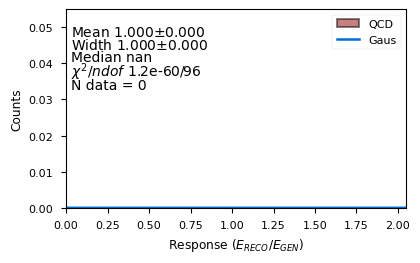

In [164]:

plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)
xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:]
# plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)
histo = output['ptresponse'].integrate('jeteta', hist.Interval(-2.5, -1.3)).integrate('pt', hist.Interval(9, 10))
histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
#     N_converge += 1

                ### Second Gaussian
xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
xvals2 = xvals[xfit_l: xfit_h]
yvals2 = yvals[xfit_l: xfit_h]
p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

ygaus = gauss(xvals, *p2)
chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
Ndof = len(xvals)-3
if chi2<50000:
    pass
    print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
else:
    print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
#             print("Fit failed because of non-convergance, p = ", p)
#     N_not_converge += 1


# fgaus = gauss(f_xvals, *p)
fgaus2 = gauss(f_xvals, *p2)

# median[i,k] = np.median(histvals)
# mean[i,k] = p[1] # - (scal-1)
# width[i,k] = p[2]
# chi2s[i,k] = chi2
#             idx.append(i)

####################### Plotting ############################
# if not test_run:
N = histo.integrate('ptresponse').values()[('QCD',)]
histo = histo.rebin('ptresponse', plot_response_axis)

h = np.max(histo.values()[('QCD',)]);
h = h if h!=0 else 0.05
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm{1:0.3f}$'.format(p2[2],np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
ax2.legend();

#     plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
#     plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf');
# plt.close();                

In [138]:
print("Welcome to {0:0.3f}, {0:0.3f} {0:0.3f}!".format(15.0,16,"C"))

Welcome to 15.000, 15.000 15.000!


In [126]:
np.sqrt(arr[1,1])

0.0020551358678628203

In [62]:
# histo = output['ptresponse'].integrate('jeteta', hist.Interval(-2.5, -1.3)).integrate('pt', hist.Interval(300, 350))
histo = output['ptresponse'].integrate('jeteta', hist.Interval(-2.5, -1.3)).integrate('pt', hist.Interval(90, 120))
h = np.max(histo.values()[('QCD',)])
h = h if h!=0 else 0.05
xvals = output['ptresponse'+samp].axis('ptresponse').centers()
yvals = histo.values()[('QCD',)]
xvals = xvals[1:]
yvals = yvals[1:]
scal = scalings.loc[-2.5,str(300.0)]
# xvals2 = xvals
p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
# try:
#     p, arr = curve_fit(gauss, xvals, yvals, p0=[1000,1,1])
#     print("Fit succeeded, p = ", p)
# except:
#     print("Fit failed, p = ", p)

### Second Gaussian
# xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
# xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
# xvals2 = xvals[xfit_l: xfit_h]
# yvals2 = yvals[xfit_l: xfit_h]
# p, arr = curve_fit(gauss, xvals2, yvals2, p0=p)
fgaus = gauss(f_xvals, *p)

histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))


median[i,k] = np.median(histvals)
mean[i,k] = p[1]-(scal-1)
width[i,k] = p[2]
idx.append(i)

ygaus = gauss(xvals, *p)
chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
N = histo.integrate('ptresponse').values()[('QCD',)]
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)
histo = histo.rebin('ptresponse', plot_response_axis)
# peak_loc = np.where(xvals<p[1])[0][-1]
# fit_left = peak_loc-4
# fit_right = peak_loc+5
# chi2 = sum((yvals[fit_left:fit_right]-ygaus[fit_left:fit_right])**2/(yvals[fit_left:fit_right]+1E-9))

In [63]:
p1 = p

In [64]:
p

array([ 1.49854016e+03,  1.00107555e+00, -1.23249320e-01])

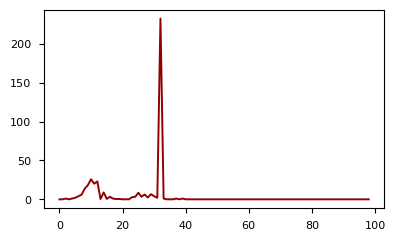

In [65]:
plt.plot((yvals-ygaus)**2/(yvals+1E-9))

In [87]:
# np.sqrt(arr[1,1])

<>:11: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_14483/320368900.py:11: DeprecationWarning: invalid escape sequence \c
  plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/97'.format(chi2))


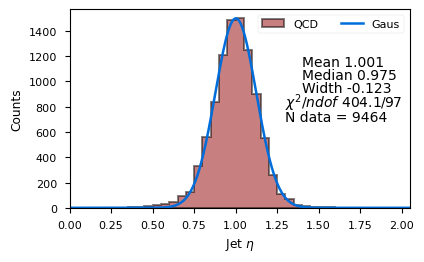

In [67]:
all# %%capture
fig, ax2 = plt.subplots()
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
# ax2.plot(f_xvals1, fgaus1, label='Gaus, excl. 1st bin',linewidth=1.8)
ax2.set_xlim(plot_pt_edges[[0,-1]])
plt.text(1.4,0.75*h,'Mean {0:0.3f}'.format(p[1]))
plt.text(1.4,0.68*h,'Median {0:0.3f}'.format(np.median(histvals)))
plt.text(1.4,0.61*h,'Width {0:0.3f}'.format(p[2]))
plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/97'.format(chi2))
plt.text(1.3,0.46*h,'N data = {0:0.0f}'.format(N))
ax2.legend(ncol=2);

plt.show();
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.png');
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.eps');
# plt.savefig('fig/ptResponse_test_excl_1st_bin'+pt_string+eta_string+'.pdf');
plt.close();

<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_14483/380541488.py:10: DeprecationWarning: invalid escape sequence \c
  plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/97'.format(chi2))


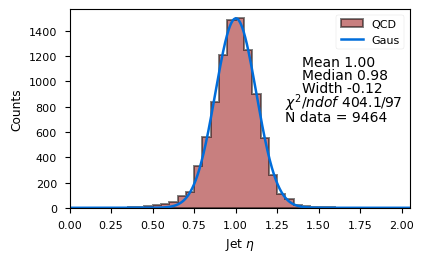

In [68]:
all# %%capture
fig, ax2 = plt.subplots()
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.set_xlim(plot_pt_edges[[0,-1]])
plt.text(1.4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
plt.text(1.4,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)))
plt.text(1.4,0.61*h,'Width {0:0.2f}'.format(p[2]))
plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/97'.format(chi2))
plt.text(1.3,0.46*h,'N data = {0:0.0f}'.format(N))
ax2.legend();

plt.show();
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.png');
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.eps');
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.pdf');
plt.close();

### Save fit data to csv's

In [88]:
# # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
# data = {str(ptBin):mean[i] for i, ptBin in enumerate(ptbins)}

# # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
# data['etaBins'] = np.array([str(etaBin) for etaBin in etabins])

# df = pd.DataFrame(data=data)
# df = df.set_index('etaBins')
# if not test_run:
#     df.to_csv('out_txt/EtaBinsvsPtBinsMean'+samp+tag_full+'.csv')
# else:
#     df.to_csv('out_txt/EtaBinsvsPtBinsMean'+tag+'_test.csv')

In [89]:
# # data_width = {str(ptBin):width[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
# data_width = {str(ptBin):width[i] for i, ptBin in enumerate(ptbins)}

# # data_width['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
# data_width['etaBins'] = [str(etaBin) for etaBin in etabins]

# df_width = pd.DataFrame(data=data_width)
# df_width = df_width.set_index('etaBins')
# if not test_run:
#     df_width.to_csv('out_txt/EtaBinsvsPtBinsWidth'+samp+tag_full+'.csv')
# else:
#     df_width.to_csv('out_txt/EtaBinsvsPtBinsWidth'+tag+'_test.csv')

In [90]:
# # data_median = {str(ptBin):median[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
# data_median = {str(ptBin):median[i] for i, ptBin in enumerate(ptbins)}

# # data_median['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
# data_median['etaBins'] = [str(etaBin) for etaBin in etabins]

# df_median = pd.DataFrame(data=data_median)
# df_median = df_median.set_index('etaBins')
# if not test_run:
#     df_median.to_csv('out_txt/EtaBinsvsPtBinsMedian'+samp+tag_full+'.csv')
# else:
#     df_median.to_csv('out_txt/EtaBinsvsPtBinsMedian'+tag+'_test.csv')

In [91]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df)
    

In [52]:
# # df[pt bin][eta bin]

# ptBin = '300'
# etaBin = '0.783'

# print('mean   =', np.round(df[ptBin][etaBin],3))
# print('median =', np.round(df_median[ptBin][etaBin],3))
# print('width  =', np.round(df_width[ptBin][etaBin],3))

In [53]:
# # df[pt bin][eta bin]

# ptBin = '300'
# etaBin = '0.783'

# print('mean   =', df[ptBin][etaBin])
# print('median =', df_median[ptBin][etaBin])
# print('width  =', df_width[ptBin][etaBin])

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [92]:
# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_csv)

         1.0  2.0       3.0      4.0       5.0       6.0       7.0       8.0  \
etaBins                                                                        
-5.0     1.0  1.0 -0.831762  0.70152  1.022921  1.027888  1.004245  1.025587   
-3.0     1.0  1.0  1.000000  1.00000  1.000000  1.000000 -3.323510 -0.056908   
-2.5     1.0  1.0  1.000000  1.00000  1.000000  0.000000  0.675000 -0.729886   
-1.3     1.0  1.0  1.000000  1.00000  1.000000 -2.092877  0.220531  0.544314   
 0.0     1.0  1.0  1.000000  1.00000  1.000000 -1.168600  0.257954  0.554183   
 1.3     1.0  1.0  1.000000  1.00000  1.000000  1.000000  0.000000 -1.047515   
 2.5     1.0  1.0 -0.011199  1.00000  1.000000  1.000000 -0.715871 -0.356600   
 3.0     0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   

              9.0      10.0      11.0      12.0      13.0      14.0      15.0  \
etaBins                                                                         
-5.0     1.024974  1.024248  1.019683